# Two-phase Navier-Stokes with surface tension

Let's consider the incompressible Navier-Stokes equations with two immiscible phases and surface tension to demonstrate more complex usage of Dune-MMesh's capabilities.

A domain $\Omega \subset \mathbb{R}^2$ is assumed to be separeted into two phases $\Omega_i(t), i=1,2,$ by a sharp interface $\Gamma(t)$.

Find $(u, p)$ and $\Gamma(t)$ s.t.
\begin{align}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\end{align}
\begin{align}
\rho u_t + \nabla \cdot (\rho u \otimes u) + \nabla \cdot T(u, p) &= 0, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\nabla \cdot u &= 0, &\qquad &\text{in } \Omega_i(t), \quad &i&=1,2,\\
\jump{ p } &= \sigma \kappa \cdot n, &\qquad &\text{on } \Gamma(t),\\
\jump{u} &= 0, &\qquad &\text{on } \Gamma(t),\\
\dot x &= u, &\qquad &x \in \Gamma(t),\\
u(0) &= u_0, &\qquad &\text{in } \Omega_i(0), \quad &i&=1,2,\\
\Gamma(0) &= \Gamma_0.
\end{align}

Here, $T(u, p) := p I - \mu (\nabla u + (\nabla u)^T))$ is the stress tensor, $\mu_i, i=1,2,$ are the dynamic viscositities and $\rho_i, i=1,2,$ the densities of the two phases, $\sigma$ is the surface tension and $\kappa$ is the signed mean curvature of the interface times its normal.

Now, we use Dune-MMesh to compute the dynamics of a droplet in a channel. Let us consider the [circle](grids/circle.rst) grid.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh, trace, skeleton, domainMarker
from dune.fem.view import adaptiveLeafGridView as adaptive

dim = 2
file = "grids/circle.msh"

gridView = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid
igridView = adaptive( hgrid.interfaceGrid )

In [2]:
from ufl import *
from dune.ufl import Constant

mu0   = Constant(   1, name="mu0")
mu1   = Constant(   1, name="mu1")
rho0  = Constant(   1, name="rho0")
rho1  = Constant(   2, name="rho1")
sigma = Constant(0.03, name="sigma")

dt = 0.05
T  = 12.0
tau  = Constant(dt, name="tau")

In [3]:
from dune.mmesh import domainMarker

dm = domainMarker(gridView)
mu  = (1-dm) * mu0  + dm * mu1
rho = (1-dm) * rho0 + dm * rho1

In [4]:
from dune.fem.space import lagrange, dglagrange

pspace = dglagrange(gridView, order=1)
p = TrialFunction(pspace)
q = TestFunction(pspace)

uspace = dglagrange(gridView, dimRange=dim, order=2)
u = TrialFunction(uspace)
v = TestFunction(uspace)

ph = pspace.interpolate(0, name="ph")
uh = uspace.interpolate([0,0], name="uh")
uh1 = uspace.interpolate([0,0], name="uh1")

## Curvature

The mean curvature $\kappa$ of the interface times its normal can be computed by solving
\begin{align*}
\int_{\Gamma} \kappa \cdot \phi + \nabla x \cdot \nabla \phi \ dS = 0, &\qquad &\text{in } \Gamma(t).\\
\end{align*}

In [5]:
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin

kspace = lagrange(igridView, dimRange=dim, order=1)
k  = TrialFunction(kspace)
kk = TestFunction(kspace)

curvature = kspace.interpolate([0]*dim, name="curvature")

ix = SpatialCoordinate(kspace)
C  = inner(k, kk) * dx
C -= inner(grad(ix), grad(kk)) * dx

kscheme = galerkin([C == 0])
res = kscheme.solve(curvature)

## Moving

We will move the interface movement by evaluating the trace of the bulk velocity $u$.

In [6]:
import numpy as np

x = SpatialCoordinate(pspace)
n = FacetNormal(pspace)
h = FacetArea(pspace)

def getShifts():
    mapper = hgrid.interfaceGrid.indexSet
    shifts = np.zeros((igridView.size(dim-1), dim))
    for e in igridView.elements:
        for v in e.subEntities(dim-1):
            x = e.geometry.toLocal(v.geometry.center)
            shifts[ mapper.index(v) ] = trace(uh)(e, x)
    return shifts

## Navier-Stokes equations

We implement a splitting scheme similar to the one presented in [GBK20]_.

.. [GBK20] J. Gerstenberger, S. Burbulla, D. Kröner. Discontinuous Galerkin method for incompressible two-phase flows. Finite Volumes for Complex Applications IX - Methods, Theoretical Aspects, Examples, pp. 675--683, 2020.

In [7]:
from dune.mmesh import skeleton, interfaceIndicator
I = interfaceIndicator(igridView)

penu = Constant(1e6, name="penaltyu")
penp = Constant(1e6, name="penaltyp")

noslip = conditional(x[0] < 1e-6, 1, 0) + conditional(x[0] > 1-1e-6, 1, 0)

a1  = rho * inner(u - uh, v) / tau * dx
a1 += inner(grad(uh) * uh, v) * dx
a1 += inner(mu * grad(u), grad(v)) * dx

a1 += penu / h * inner(jump(u), jump(v)) * dS
a1 += dot(dot(avg(mu * grad(u)), n('+')), jump(v)) * dS
a1 += penu / h * inner(u - zero(dim), v) * noslip * ds
a1 += dot(dot(mu * grad(u), n), v) * noslip * ds

A1 = galerkin([a1 == 0], solver=("suitesparse", "umfpack"))


dirichlet = conditional(x[1] < 1e-6, 1, 0) + conditional(x[1] > 2-1e-6, 1, 0)
pD = conditional(x[1] < 1e-6, 1, 0)

a2  = inner(grad(p), grad(q)) * dx
a2 += penp / h * jump(p) * jump(q) * dS
a2 += dot(dot(avg(grad(p)), n('+')), jump(q)) * dS
a2 += penp / h * (p - pD) * q * dirichlet * ds
a2 += dot(dot(grad(p), n), q) * ds
a2 += inner(rho * div(uh1), q) / tau * dx

kappa = avg(skeleton(curvature))
a2 += penp / h * inner(sigma * kappa, n('+')) * jump(q) * I*dS

A2 = galerkin([a2 == 0], solver=("suitesparse", "umfpack"))


a3  = rho * inner(u - uh1, v) / tau * dx
a3 += inner(grad(ph), v) * dx

a3 += penu / h * inner(jump(u), jump(v)) * dS
a3 += penu / h * inner(u - zero(dim), v) * noslip * ds

A3 = galerkin([a3 == 0], solver=("suitesparse", "umfpack"))

## Timeloop

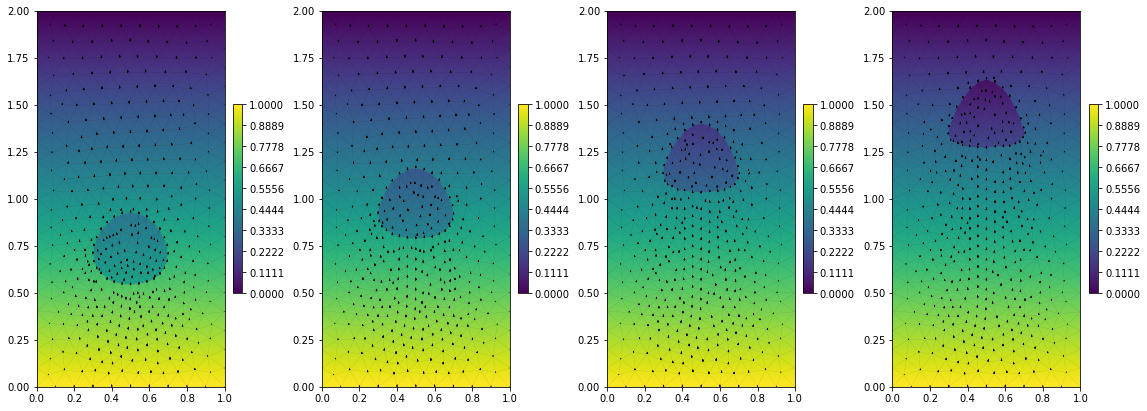

In [8]:
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as plt

N = 4
i = 0
fig, axs = plt.subplots(1, N, figsize=(16,6))

ph.interpolate(0)
uh.interpolate([0,0])
uh1.interpolate([0,0])

step = 0
t = 0
while t < T+dt:
    
    hgrid.moveInterface( dt*getShifts() )
    
    hgrid.markElements()
    adapt([ph, uh, uh1, dm])
    adapt([curvature])
    
    A1.solve(uh1)
    A2.solve(ph)
    A3.solve(uh)

    if int(N * t/T) > i:
        plot(ph, figure=(fig, axs[i]), gridLines='black', linewidth=0.02)
        plot(uh, figure=(fig, axs[i]), gridLines=None, vectors=[0,1])
        i += 1

    t += dt